<a href="https://colab.research.google.com/github/m-aliabbas/GAN/blob/main/GANColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/synthea-public/synthea_sample_data_csv_apr2020.zip
!unzip synthea_sample_data_csv_apr2020.zip

--2020-12-31 15:28:47--  https://storage.googleapis.com/synthea-public/synthea_sample_data_csv_apr2020.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8982431 (8.6M) [application/zip]
Saving to: ‘synthea_sample_data_csv_apr2020.zip’

synthea_sample_data 100%[===================>]   8.57M  47.4MB/s    in 0.2s    

2020-12-31 15:28:47 (47.4 MB/s) - ‘synthea_sample_data_csv_apr2020.zip’ saved [8982431/8982431]

Archive:  synthea_sample_data_csv_apr2020.zip
   creating: csv/
  inflating: csv/medications.csv     
  inflating: csv/providers.csv       
  inflating: csv/payer_transitions.csv  
  inflating: csv/imaging_studies.csv  
  inflating: csv/supplies.csv        
  inflating: csv/payers.csv          
  inflating: csv/allergies.csv       
  inflating: csv/procedures.csv     

In [2]:
import pandas as pd

df = pd.read_csv('csv/patients.csv')
df.drop(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'ADDRESS', 'LAST', 'SUFFIX', 'MAIDEN','LAT', 'LON',], axis=1, inplace=True)
print(df.columns)

Index(['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE',
       'COUNTY', 'ZIP', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'],
      dtype='object')


In [3]:
df["MARITAL"] = df["MARITAL"].astype('category').cat.codes
df["RACE"] = df["RACE"].astype('category').cat.codes
df["ETHNICITY"] = df["ETHNICITY"].astype('category').cat.codes
df["GENDER"] = df["GENDER"].astype('category').cat.codes
df["BIRTHPLACE"] = df["BIRTHPLACE"].astype('category').cat.codes
df["CITY"] = df["CITY"].astype('category').cat.codes
df["STATE"] = df["STATE"].astype('category').cat.codes
df["COUNTY"] = df["COUNTY"].astype('category').cat.codes
df["ZIP"] = df["ZIP"].astype('category').cat.codes

df.head()

,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,0,4,0,1,136,42,0,6,2,271227.08,1334.88
1,0,4,1,1,61,186,0,8,132,793946.01,3204.49
2,0,4,1,1,236,42,0,6,3,574111.90,2606.40
3,0,4,1,0,291,110,0,8,68,935630.30,8756.19
4,-1,4,1,1,189,24,0,12,125,598763.07,3772.20


In [4]:
df.shape

(1171, 11)

In [6]:
HEALTHCARE_EXPENSES_MIN = df["HEALTHCARE_EXPENSES"].min()
HEALTHCARE_EXPENSES_MAX = df["HEALTHCARE_EXPENSES"].max()
print('Min and max healthcare expense', HEALTHCARE_EXPENSES_MIN, HEALTHCARE_EXPENSES_MAX)

HEALTHCARE_COVERAGE_MIN = df["HEALTHCARE_COVERAGE"].min()
HEALTHCARE_COVERAGE_MAX = df["HEALTHCARE_COVERAGE"].max()

print('Min and max healthcare coverage', HEALTHCARE_COVERAGE_MIN, HEALTHCARE_COVERAGE_MAX)


Min and max healthcare expense 1822.1600000000005 2145924.400000002
Min and max healthcare coverage 0.0 927873.5300000022


In [7]:
import numpy as np

df_healthcare_expenses = pd.cut(df['HEALTHCARE_EXPENSES'], bins=np.linspace(HEALTHCARE_EXPENSES_MIN, HEALTHCARE_EXPENSES_MAX, 21), labels=False)
df_healthcare_coverage = pd.cut(df['HEALTHCARE_COVERAGE'], bins=np.linspace(HEALTHCARE_COVERAGE_MIN, HEALTHCARE_COVERAGE_MAX, 21), labels=False)

df.drop(["HEALTHCARE_EXPENSES", "HEALTHCARE_COVERAGE"], axis=1, inplace=True)

df = pd.concat([df, df_healthcare_expenses, df_healthcare_coverage], axis=1)

In [8]:
from sklearn.preprocessing import PowerTransformer

df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])

print(df)

       MARITAL      RACE  ...  HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE
0     0.334507  0.461541  ...            -0.819522            -0.187952
1     0.334507  0.461541  ...             0.259373            -0.187952
2     0.334507  0.461541  ...            -0.111865            -0.187952
3     0.334507  0.461541  ...             0.426979            -0.187952
4    -1.275676  0.461541  ...            -0.111865            -0.187952
...        ...       ...  ...                  ...                  ...
1166  0.334507 -2.207146  ...             1.398831            -0.187952
1167  1.773476  0.461541  ...             0.585251            -0.187952
1168  1.773476  0.461541  ...             1.275817             5.320497
1169  0.334507  0.461541  ...             1.016430            -0.187952
1170  0.334507  0.461541  ...             1.275817            -0.187952

[1171 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [9]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [10]:
data_cols = df.columns

In [11]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = 'model'

df[data_cols] = df[data_cols]

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

11


In [12]:
!mkdir model

In [13]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

0 [D loss: 0.697213, acc.: 34.38%] [G loss: 0.668736]
generated_data
1 [D loss: 0.648874, acc.: 50.00%] [G loss: 0.651074]
2 [D loss: 0.636558, acc.: 50.00%] [G loss: 0.628234]
3 [D loss: 0.619579, acc.: 50.00%] [G loss: 0.627685]
4 [D loss: 0.606732, acc.: 50.00%] [G loss: 0.648490]
5 [D loss: 0.602260, acc.: 50.00%] [G loss: 0.694899]
6 [D loss: 0.564397, acc.: 53.12%] [G loss: 0.789757]
7 [D loss: 0.545212, acc.: 56.25%] [G loss: 0.892711]
8 [D loss: 0.536157, acc.: 60.94%] [G loss: 0.903668]
9 [D loss: 0.608470, acc.: 50.00%] [G loss: 0.894977]
10 [D loss: 0.640221, acc.: 45.31%] [G loss: 0.840668]
11 [D loss: 0.651961, acc.: 45.31%] [G loss: 0.929463]
12 [D loss: 0.610368, acc.: 48.44%] [G loss: 1.090915]
13 [D loss: 0.498053, acc.: 92.19%] [G loss: 1.291962]
14 [D loss: 0.488005, acc.: 92.19%] [G loss: 1.388878]
15 [D loss: 0.492455, acc.: 85.94%] [G loss: 1.360386]
16 [D loss: 0.504501, acc.: 84.38%] [G loss: 1.199058]
17 [D loss: 0.527631, acc.: 84.38%] [G loss: 1.122829]
18 [D

KeyboardInterrupt: ignored

In [14]:
!mkdir model/gan
!mkdir model/gan/saved

In [15]:
synthesizer.save('model/gan/saved', 'generator_patients')

In [16]:
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 32)]                0         
_________________________________________________________________
dense (Dense)                (32, 128)                 4224      
_________________________________________________________________
dense_1 (Dense)              (32, 256)                 33024     
_________________________________________________________________
dense_2 (Dense)              (32, 512)                 131584    
_________________________________________________________________
dense_3 (Dense)              (32, 11)                  5643      
Total params: 174,475
Trainable params: 174,475
Non-trainable params: 0
_________________________________________________________________


In [17]:
synthesizer.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 11)]                0         
_________________________________________________________________
dense_4 (Dense)              (32, 512)                 6144      
_________________________________________________________________
dropout (Dropout)            (32, 512)                 0         
_________________________________________________________________
dense_5 (Dense)              (32, 256)                 131328    
_________________________________________________________________
dropout_1 (Dropout)          (32, 256)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 128)                 32896     
_________________________________________________________________
dense_7 (Dense)              (32, 1)                   129 

In [18]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

No handles with labels found to put in legend.


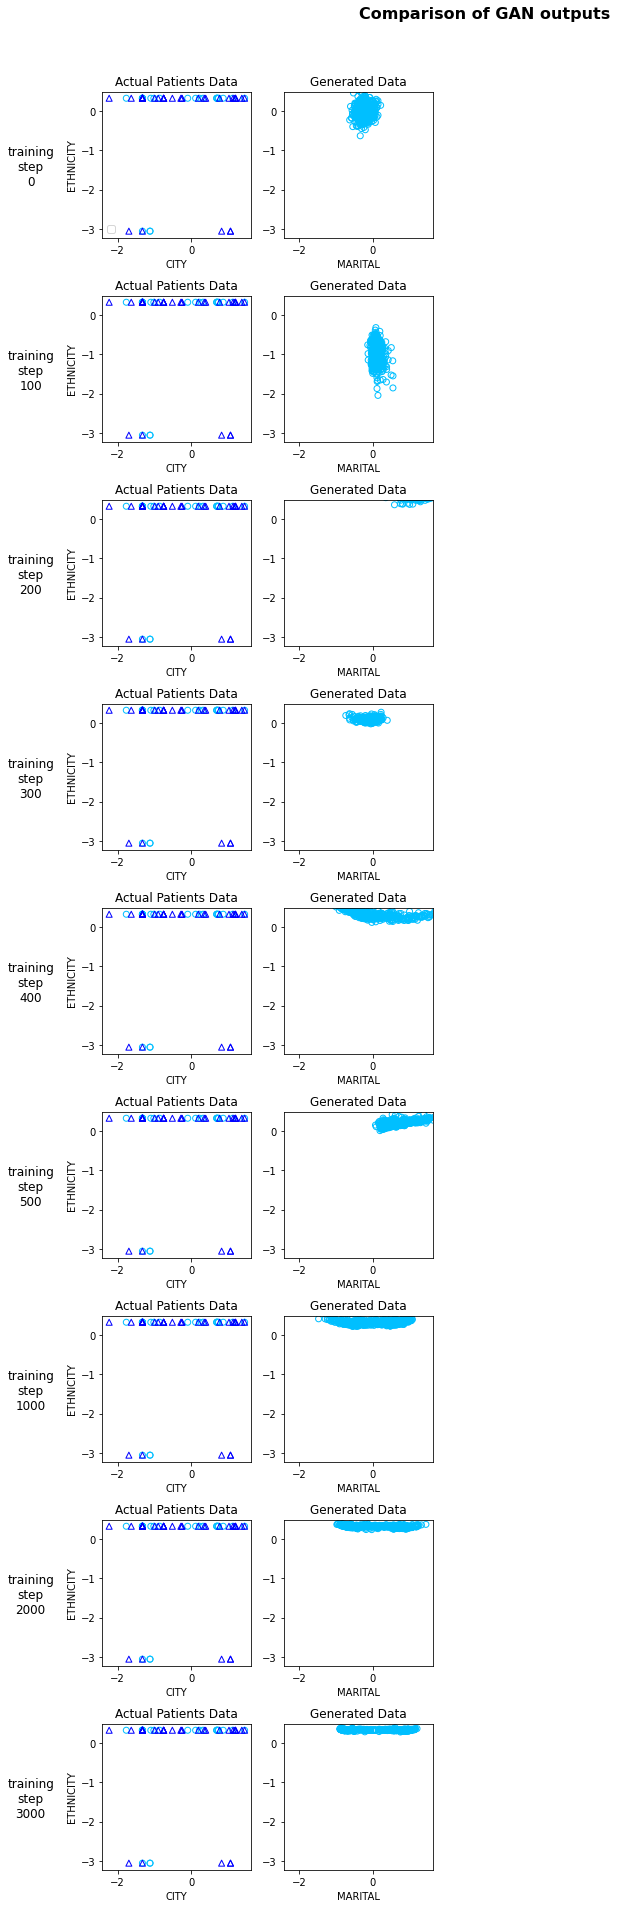

In [20]:
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'CITY', 'ETHNICITY'

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby('RACE'), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Patients Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

In [25]:
!ls

Comparison_of_GAN_outputs.png  model
csv			       sample_data
Generated_sample.csv	       synthea_sample_data_csv_apr2020.zip


In [21]:
!pip install table_evaluator

  Created wheel for table-evaluator: filename=table_evaluator-1.2.2.post1-cp36-none-any.whl size=17055 sha256=4bef47f77817d6fda307dbe6b198325a7ad8e570180fa36a1e914e8bef28ec73
  Stored in directory: /root/.cache/pip/wheels/a9/4d/9d/62b61486fc85b53ef9bf7979a52cda067a514c2a7a05c49bd4
Successfully built table-evaluator


In [29]:
gen_df=pd.read_csv('Generated_sample.csv',index_col='Unnamed: 0')

In [30]:
gen_df

,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,CITY,STATE,COUNTY,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,0.321054,0.440433,0.334023,-0.946994,0.180407,0.595330,0.019613,1.265320,-1.021467,0.692129,-0.191536
1,0.322479,0.452373,0.341890,-0.973163,0.182858,0.580808,0.023756,1.282037,-1.039570,0.726379,-0.193259
2,0.333761,0.456491,0.319635,-0.936102,-1.478175,-0.791255,0.019882,-1.485787,-1.015358,1.117158,-0.176829
3,0.354960,0.489849,0.351038,-0.987246,0.208658,-0.531289,0.036592,-1.522642,-1.099508,1.062346,-0.192553
4,0.352007,0.472046,0.334832,-0.984607,-1.583131,-0.834688,0.021695,-1.533648,-1.062446,1.190970,-0.183338
...,...,...,...,...,...,...,...,...,...,...,...
487,0.350501,0.474524,0.320392,-0.944508,-1.519719,-0.799716,0.043118,-1.488210,-1.042532,1.156495,-0.177314
488,0.352268,0.475517,0.323814,-0.947511,-1.480830,-0.781892,0.033665,-1.476769,-1.039549,1.164365,-0.187369
489,0.340348,0.485465,0.355965,-0.997341,-1.174088,0.958592,0.015902,1.383093,-1.058454,1.167937,-0.178675
490,0.338538,0.445869,0.298239,-0.882573,0.025055,-0.503327,0.030296,-1.378822,-0.985133,0.962909,-0.205048


1171 492


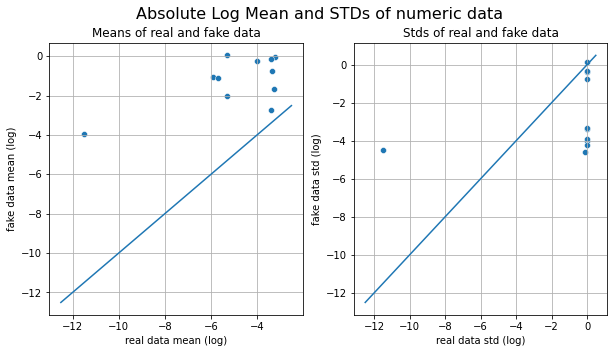

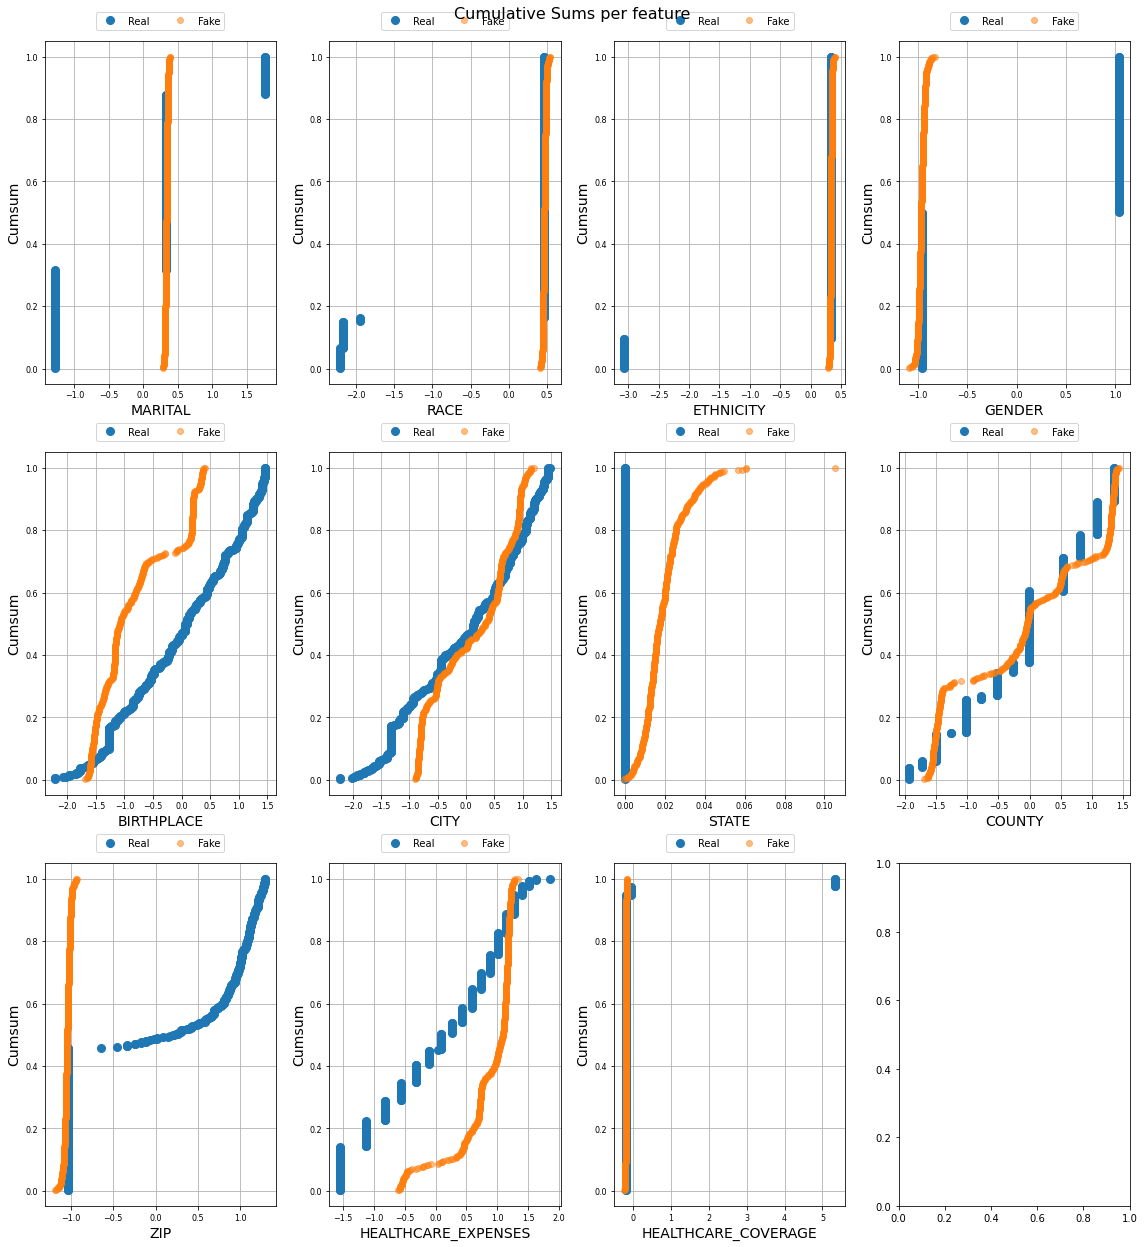

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

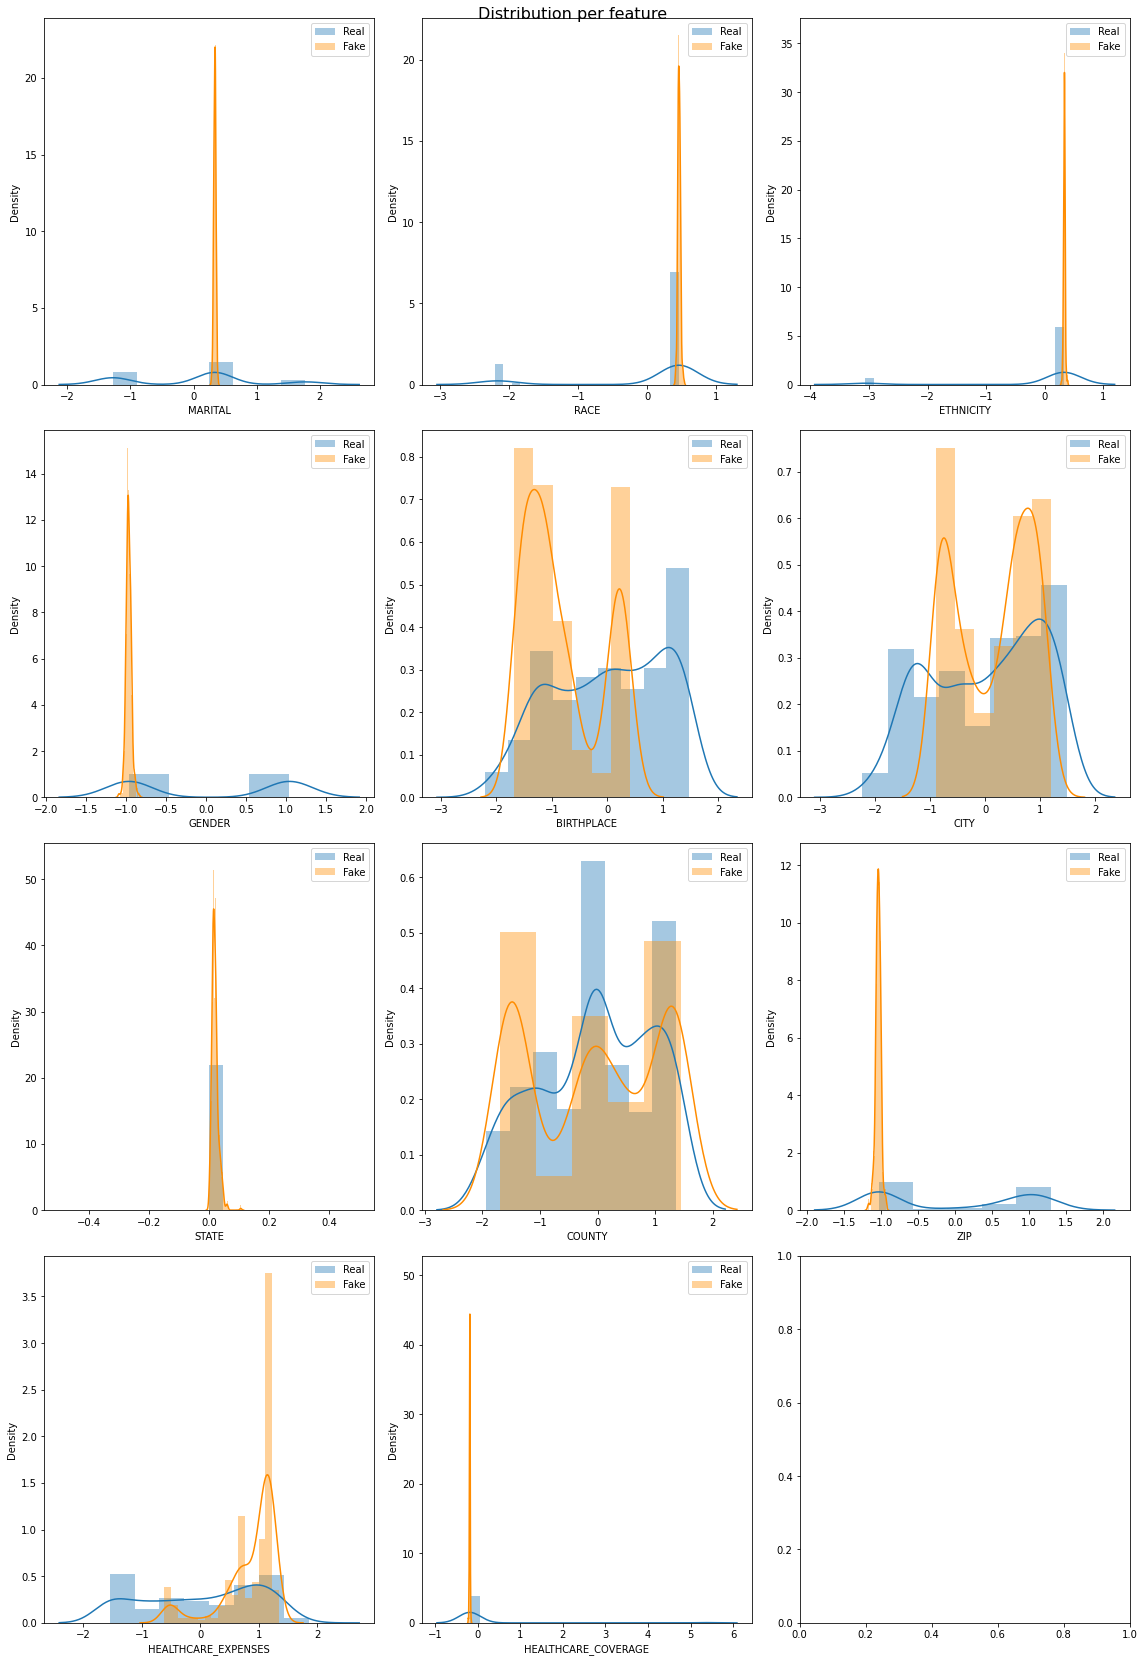

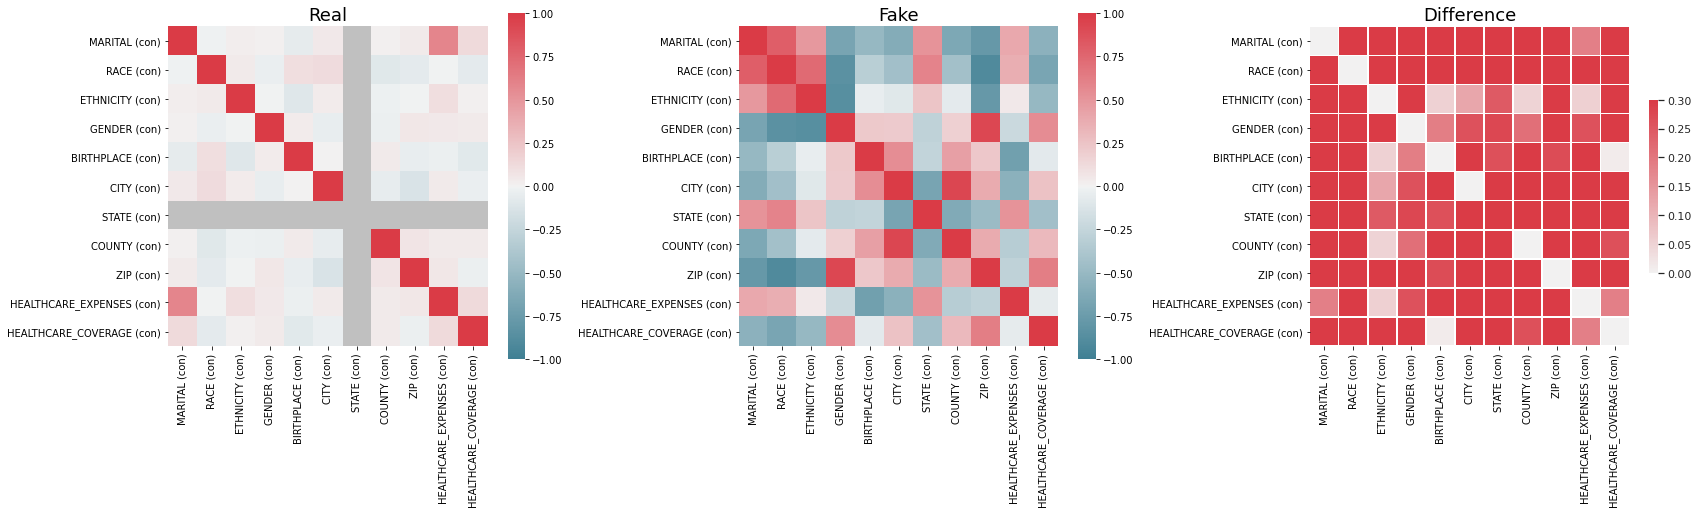

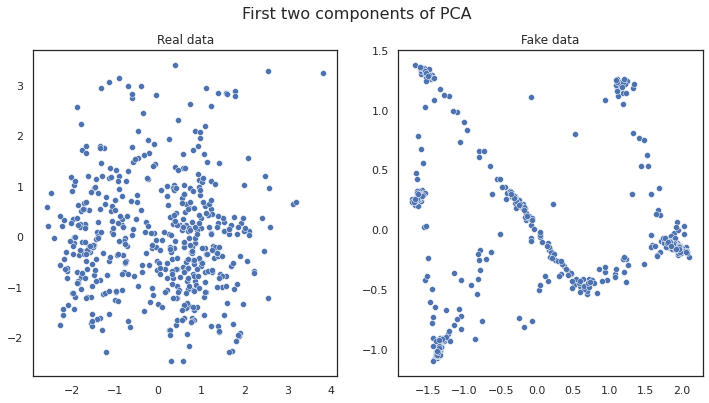

In [31]:
from table_evaluator import load_data, TableEvaluator

cat_cols = ['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'CITY', 'STATE', 'COUNTY', 'ZIP']

print(len(df), len(gen_df))
table_evaluator =  TableEvaluator(df, gen_df)

table_evaluator.visual_evaluation()